<a href="https://colab.research.google.com/github/kiradawa/Stocks-prediction/blob/main/Deep_leaning_PRO_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mahmood Yaghi
#202011134

#Stock Price prediction
I'm going to make a Dense NN model and use the same data used by user SIDDHARTH YADAV His account https://www.kaggle.com/thebrownviking20 and I'm going to compare my work with him and see the results. His work: https://www.kaggle.com/code/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru

In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 622 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import  Dense
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import math

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#data preparation

Extract data

In [ ]:
data = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Deep learning project/IBM_2006-01-01_to_2018-01-01.csv", index_col='Date', parse_dates=['Date'])
data

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM
...,...,...,...,...,...,...
2017-12-22,151.82,153.00,151.50,152.50,2990583,IBM
2017-12-26,152.51,153.86,152.50,152.83,2479017,IBM
2017-12-27,152.95,153.18,152.61,153.13,2149257,IBM


Understanding the data

In [ ]:
data.describe()

,Open,High,Low,Close,Volume
count,3019.000000,3020.000000,3019.000000,3020.000000,3.020000e+03
mean,145.515545,146.681738,144.471597,145.617278,5.773301e+06
std,37.554946,37.613446,37.477641,37.529387,3.192831e+06
min,72.740000,73.940000,69.500000,71.740000,2.542560e+05
25%,116.405000,117.765000,115.490000,116.525000,3.622681e+06
50%,149.610000,150.330000,148.470000,149.315000,4.928852e+06
75%,178.445000,179.762500,177.330000,178.685000,6.965014e+06
max,215.380000,215.900000,214.300000,215.800000,3.077428e+07


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3020 entries, 2006-01-03 to 2017-12-29
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    3019 non-null   float64
 1   High    3020 non-null   float64
 2   Low     3019 non-null   float64
 3   Close   3020 non-null   float64
 4   Volume  3020 non-null   int64  
 5   Name    3020 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 165.2+ KB


Both Open and Low columns have missing values 

In [ ]:
data.isnull().sum()

Open      1
High      0
Low       1
Close     0
Volume    0
Name      0
dtype: int64

But since we only need High so we'll ignore it.

The max High stock price each year

In [ ]:
for i in range(2006,2018):
  result=data["High"][str(i)].max()
  print('the max High value for',i,':',result)

the max High value for 2006 : 97.88
the max High value for 2007 : 121.46
the max High value for 2008 : 130.93
the max High value for 2009 : 132.85
the max High value for 2010 : 147.53
the max High value for 2011 : 194.9
the max High value for 2012 : 211.79
the max High value for 2013 : 215.9
the max High value for 2014 : 199.21
the max High value for 2015 : 176.3
the max High value for 2016 : 169.95
the max High value for 2017 : 182.79


we are going to be training the data from 2006 till the end of 2016 and the testing is going to be the entire year of 2017

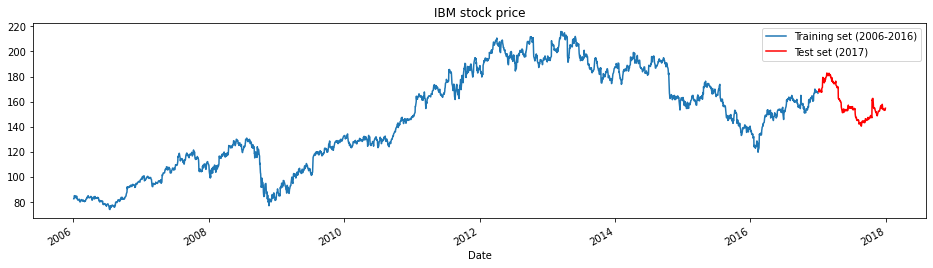

In [ ]:
data["High"][:'2016'].plot(figsize=(16,4),legend=True)
data["High"]['2017':].plot(figsize=(16,4),legend=True,color='red')
plt.legend(['Training set (2006-2016)','Test set (2017)'])
plt.title('IBM stock price')
plt.show()

#model preparation

The train test split (Train 2006-2016) (Test 2017)

In [ ]:
train = data[:'2016'].iloc[:,1:2].values
test = data['2017':].iloc[:,1:2].values
print(len(train))
print(len(test))

2769
251


We'll be scaling the training data to make them from 0 to 1

Reference: https://www.simplilearn.com/tutorials/machine-learning-tutorial/stock-price-prediction-using-machine-learning

we'll scale the data in to a specific range using each feature's minimum and maximum value.
The performance of our models might be harmed by the scale of data being considerably different for some features compared to others. This is especially true for algorithms like neural networks that depend on distance measurements.

In [ ]:
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(train)
train_scaled

array([[0.06065089],
       [0.06029868],
       [0.06311637],
       ...,
       [0.66074951],
       [0.65546633],
       [0.6534235 ]])

Creating a data structure with 60 timesteps and 1 output
So for every of training set we have 60 previous training set elements that acts as a memory to predict the y value.
basically 2 months of data to predict the next day

In [ ]:
len(data)-len(test)

2769

In [ ]:
x_train = []
y_train = []
for i in range(60,2769):
  x_train.append(train_scaled[i-60:i,0])
  y_train.append(train_scaled[i,0])
x_train = np.array(x_train)
y_train = np.array(y_train)

In [ ]:
print(x_train[0])
print(y_train[0])
print("Shape:",x_train.shape)
print("Shape:",y_train.shape)

[0.06065089 0.06029868 0.06311637 0.0781206  0.07262609 0.07171034
 0.07657087 0.07058326 0.0669907  0.06494787 0.075796   0.07361229
 0.06417301 0.05621302 0.05783319 0.05409975 0.05431107 0.05515638
 0.05543815 0.05677656 0.05846717 0.05388842 0.04811214 0.04233587
 0.04402649 0.0490279  0.04832347 0.05297267 0.05614258 0.05290223
 0.05325444 0.04909834 0.04994365 0.04797126 0.05431107 0.05212736
 0.04726684 0.04895745 0.04656241 0.04839391 0.04416737 0.0485348
 0.04719639 0.04825303 0.05395886 0.05663567 0.05853762 0.05959425
 0.06375035 0.06917442 0.06889265 0.06670893 0.06910397 0.07783883
 0.07565511 0.07276698 0.06889265 0.0656523  0.06656805 0.06769513]
0.06875176105945335
Shape: (2709, 60)
Shape: (2709,)


reshaping x_train so we will take the values separately in sets of 60 for efficient modelling 

In [ ]:
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape

(2709, 60, 1)

In [ ]:
x_train[0]

array([[0.06065089],
       [0.06029868],
       [0.06311637],
       [0.0781206 ],
       [0.07262609],
       [0.07171034],
       [0.07657087],
       [0.07058326],
       [0.0669907 ],
       [0.06494787],
       [0.075796  ],
       [0.07361229],
       [0.06417301],
       [0.05621302],
       [0.05783319],
       [0.05409975],
       [0.05431107],
       [0.05515638],
       [0.05543815],
       [0.05677656],
       [0.05846717],
       [0.05388842],
       [0.04811214],
       [0.04233587],
       [0.04402649],
       [0.0490279 ],
       [0.04832347],
       [0.05297267],
       [0.05614258],
       [0.05290223],
       [0.05325444],
       [0.04909834],
       [0.04994365],
       [0.04797126],
       [0.05431107],
       [0.05212736],
       [0.04726684],
       [0.04895745],
       [0.04656241],
       [0.04839391],
       [0.04416737],
       [0.0485348 ],
       [0.04719639],
       [0.04825303],
       [0.05395886],
       [0.05663567],
       [0.05853762],
       [0.059

we will concat the dataset to only include high

In [ ]:
data_total = pd.concat((data["High"][:'2016'],data["High"]['2017':]),axis=0)
data_total

Date
2006-01-03     82.55
2006-01-04     82.50
2006-01-05     82.90
2006-01-06     85.03
2006-01-09     84.25
               ...  
2017-12-22    153.00
2017-12-26    153.86
2017-12-27    153.18
2017-12-28    154.12
2017-12-29    154.72
Name: High, Length: 3020, dtype: float64

In [ ]:
len(data_total)-len(test)

2769

we'll make input take the last 60 inputs of the train data and all the test data.
we need the last 60 inputs to predict the first day of test

In [ ]:
inputs = data_total[len(data_total)-len(test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [ ]:
len(test)+60

311

In [ ]:
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

#Model1
using 1 layer with number of neuorns being 2^n n=3,4,5,...

In [ ]:
def train_H1(n):
   model = Sequential([
        Dense(units=n, input_shape=(60,),activation='relu'),
        Dense(units=1,activation='linear')
    ])

   model.compile(optimizer='adam',
                loss='mean_squared_error')
   return model

In [ ]:
Model1 = train_H1(8)
Model1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 8)                 488       
                                                                 
 dense_15 (Dense)            (None, 1)                 9         
                                                                 
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


In [ ]:
es = EarlyStopping(monitor='loss', verbose=1, patience=25)

Model1.fit(x_train, y_train, epochs=1000,verbose=0, callbacks=[es])

Epoch 309: early stopping


8/8 [==============================] - 0s 3ms/step


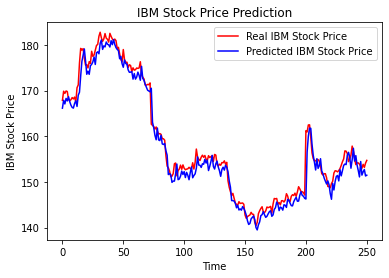

The root mean squared error is 2.0898921596951614.


In [ ]:
y_pred = Model1.predict(X_test)
y_pred = sc.inverse_transform(y_pred)
plt.plot(test, color='red',label='Real IBM Stock Price')
plt.plot(y_pred, color='blue',label='Predicted IBM Stock Price')
plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price')
plt.legend()
plt.show()
rmse = math.sqrt(mean_squared_error(test, y_pred))
print("The root mean squared error is {}.".format(rmse))

neuorns 16

In [ ]:
Model1_1 = train_H1(16)
Model1_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                976       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 993
Trainable params: 993
Non-trainable params: 0
_________________________________________________________________


In [ ]:
es = EarlyStopping(monitor='loss', verbose=1, patience=25)

Model1_1.fit(x_train, y_train, epochs=1000,verbose=0, callbacks=[es])

Epoch 278: early stopping


8/8 [==============================] - 0s 2ms/step


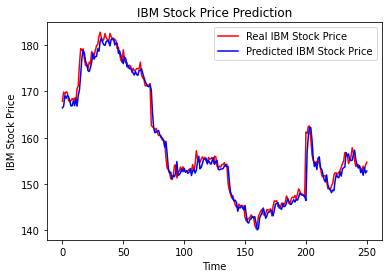

The root mean squared error is 1.7666275649793564.


In [ ]:
y_pred = Model1_1.predict(X_test)
y_pred = sc.inverse_transform(y_pred)
plt.plot(test, color='red',label='Real IBM Stock Price')
plt.plot(y_pred, color='blue',label='Predicted IBM Stock Price')
plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price')
plt.legend()
plt.show()
rmse = math.sqrt(mean_squared_error(test, y_pred))
print("The root mean squared error is {}.".format(rmse))

32

In [ ]:
Model1_2 = train_H1(32)
Model1_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 32)                1952      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,985
Trainable params: 1,985
Non-trainable params: 0
_________________________________________________________________


In [ ]:


es = EarlyStopping(monitor='loss', verbose=1, patience=25)

Model1_2.fit(x_train, y_train, epochs=1000,verbose=0, callbacks=[es])

Epoch 262: early stopping


8/8 [==============================] - 0s 2ms/step


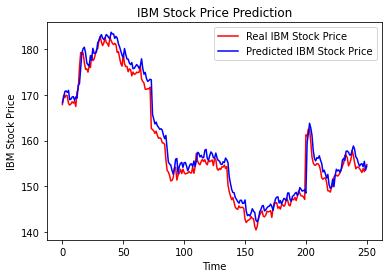

The root mean squared error is 2.157943530379578.


In [ ]:
y_pred = Model1_2.predict(X_test)
y_pred = sc.inverse_transform(y_pred)
plt.plot(test, color='red',label='Real IBM Stock Price')
plt.plot(y_pred, color='blue',label='Predicted IBM Stock Price')
plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price')
plt.legend()
plt.show()
rmse = math.sqrt(mean_squared_error(test, y_pred))
print("The root mean squared error is {}.".format(rmse))

64

In [ ]:
Model1_3 = train_H1(64)
Model1_3.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 64)                3904      
                                                                 
 dense_17 (Dense)            (None, 1)                 65        
                                                                 
Total params: 3,969
Trainable params: 3,969
Non-trainable params: 0
_________________________________________________________________


In [ ]:

es = EarlyStopping(monitor='loss', verbose=1, patience=25)

Model1_3.fit(x_train, y_train, epochs=1000,verbose=0, callbacks=[es])

Epoch 117: early stopping


8/8 [==============================] - 0s 1ms/step


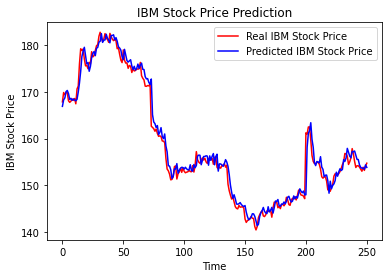

The root mean squared error is 1.7389707285295049.


In [ ]:
y_pred = Model1_3.predict(X_test)
y_pred = sc.inverse_transform(y_pred)
plt.plot(test, color='red',label='Real IBM Stock Price')
plt.plot(y_pred, color='blue',label='Predicted IBM Stock Price')
plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price')
plt.legend()
plt.show()
rmse = math.sqrt(mean_squared_error(test, y_pred))
print("The root mean squared error is {}.".format(rmse))

In [ ]:
Model1_4 = train_H1(128)
Model1_4.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 128)               7808      
                                                                 
 dense_19 (Dense)            (None, 1)                 129       
                                                                 
Total params: 7,937
Trainable params: 7,937
Non-trainable params: 0
_________________________________________________________________


In [ ]:
es = EarlyStopping(monitor='loss', verbose=1, patience=25)

Model1_4.fit(x_train, y_train, epochs=1000,verbose=0, callbacks=[es])

Epoch 97: early stopping


8/8 [==============================] - 0s 2ms/step


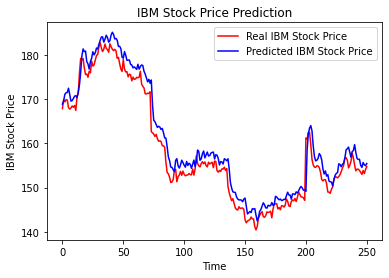

The root mean squared error is 2.822506547501928.


In [ ]:
y_pred = Model1_4.predict(X_test)
y_pred = sc.inverse_transform(y_pred)
plt.plot(test, color='red',label='Real IBM Stock Price')
plt.plot(y_pred, color='blue',label='Predicted IBM Stock Price')
plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price')
plt.legend()
plt.show()
rmse = math.sqrt(mean_squared_error(test, y_pred))
print("The root mean squared error is {}.".format(rmse))

In [ ]:
Model1_5 = train_H1(256)
Model1_5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 256)               15616     
                                                                 
 dense_11 (Dense)            (None, 1)                 257       
                                                                 
Total params: 15,873
Trainable params: 15,873
Non-trainable params: 0
_________________________________________________________________


In [ ]:
es = EarlyStopping(monitor='loss', verbose=1, patience=25)

Model1_5.fit(x_train, y_train, epochs=1000,verbose=0, callbacks=[es])

Epoch 104: early stopping


8/8 [==============================] - 0s 2ms/step


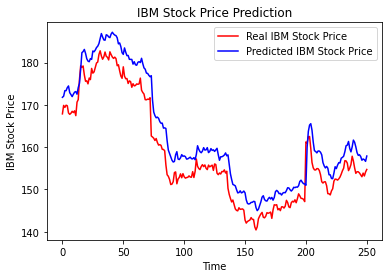

The root mean squared error is 4.7329144832433.


In [ ]:
y_pred = Model1_5.predict(X_test)
y_pred = sc.inverse_transform(y_pred)
plt.plot(test, color='red',label='Real IBM Stock Price')
plt.plot(y_pred, color='blue',label='Predicted IBM Stock Price')
plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price')
plt.legend()
plt.show()
rmse = math.sqrt(mean_squared_error(test, y_pred))
print("The root mean squared error is {}.".format(rmse))

it seems it starts to overfit here so we stop increasing and take the best model which in this case with 64 neurons

#Model2
we will try to increase the parameters by a small amount by adding a layer with 8 neurons

In [ ]:
Model2 = Sequential([
        Dense(units=64, input_shape=(60,),activation='relu'),
        Dense(units=8,activation='relu'),
        Dense(units=1,activation='linear')
    ])
Model2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 64)                3904      
                                                                 
 dense_20 (Dense)            (None, 8)                 520       
                                                                 
 dense_21 (Dense)            (None, 1)                 9         
                                                                 
Total params: 4,433
Trainable params: 4,433
Non-trainable params: 0
_________________________________________________________________


In [ ]:
Model2.compile(optimizer='adam',
                loss='mean_squared_error')
es = EarlyStopping(monitor='loss', verbose=1, patience=25)

Model2.fit(x_train, y_train, epochs=1000,verbose=0, callbacks=[es])

Epoch 106: early stopping


8/8 [==============================] - 0s 2ms/step


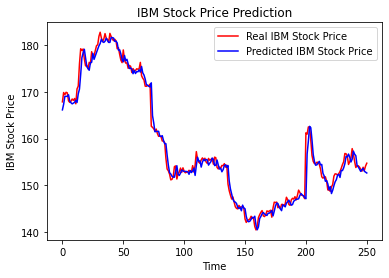

The root mean squared error is 1.689015634641087.


In [ ]:
y_pred = Model2.predict(X_test)
y_pred = sc.inverse_transform(y_pred)
plt.plot(test, color='red',label='Real IBM Stock Price')
plt.plot(y_pred, color='blue',label='Predicted IBM Stock Price')
plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price')
plt.legend()
plt.show()
rmse = math.sqrt(mean_squared_error(test, y_pred))
print("The root mean squared error is {}.".format(rmse))

there seems to be improvements so we'll increase the parameters again

In [ ]:
Model2_1 = Sequential([
        Dense(units=64, input_shape=(60,),activation='relu'),
        Dense(units=16,activation='relu'),
        Dense(units=1,activation='linear')
    ])
Model2_1.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 64)                3904      
                                                                 
 dense_45 (Dense)            (None, 16)                1040      
                                                                 
 dense_46 (Dense)            (None, 1)                 17        
                                                                 
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________


In [ ]:
Model2_1.compile(optimizer='adam',
                loss='mean_squared_error')
es = EarlyStopping(monitor='loss', verbose=1, patience=25)

Model2_1.fit(x_train, y_train, epochs=1000,verbose=0, callbacks=[es])

Epoch 167: early stopping


8/8 [==============================] - 0s 2ms/step


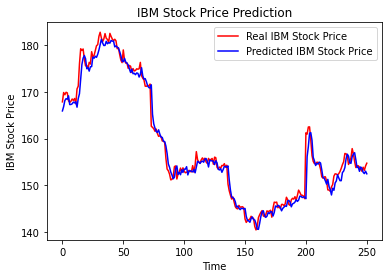

The root mean squared error is 1.8120427068293363.


In [ ]:
y_pred = Model2_1.predict(X_test)
y_pred = sc.inverse_transform(y_pred)
plt.plot(test, color='red',label='Real IBM Stock Price')
plt.plot(y_pred, color='blue',label='Predicted IBM Stock Price')
plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price')
plt.legend()
plt.show()
rmse = math.sqrt(mean_squared_error(test, y_pred))
print("The root mean squared error is {}.".format(rmse))

In [ ]:
Model2_2 = Sequential([
        Dense(units=64, input_shape=(60,),activation='relu'),
        Dense(units=32,activation='relu'),
        Dense(units=1,activation='linear')
    ])
Model2_2.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_107 (Dense)           (None, 64)                3904      
                                                                 
 dense_108 (Dense)           (None, 32)                2080      
                                                                 
 dense_109 (Dense)           (None, 1)                 33        
                                                                 
Total params: 6,017
Trainable params: 6,017
Non-trainable params: 0
_________________________________________________________________


In [ ]:
Model2_2.compile(optimizer='adam',
                loss='mean_squared_error')
es = EarlyStopping(monitor='loss', verbose=1, patience=25)

Model2_2.fit(x_train, y_train, epochs=1000,verbose=0, callbacks=[es])

Epoch 67: early stopping


8/8 [==============================] - 0s 2ms/step


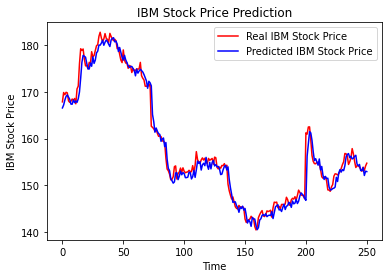

The root mean squared error is 1.821500074182721.


In [ ]:
y_pred = Model2_2.predict(X_test)
y_pred = sc.inverse_transform(y_pred)
plt.plot(test, color='red',label='Real IBM Stock Price')
plt.plot(y_pred, color='blue',label='Predicted IBM Stock Price')
plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price')
plt.legend()
plt.show()
rmse = math.sqrt(mean_squared_error(test, y_pred))
print("The root mean squared error is {}.".format(rmse))

#Model3

In [ ]:
Model3 = Sequential([
        Dense(units=64, input_shape=(60,),activation='relu'),
        Dense(units=8,activation='relu'),
        Dense(units=8,activation='relu'),
        Dense(units=1,activation='linear')
    ])
Model3.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_114 (Dense)           (None, 64)                3904      
                                                                 
 dense_115 (Dense)           (None, 8)                 520       
                                                                 
 dense_116 (Dense)           (None, 8)                 72        
                                                                 
 dense_117 (Dense)           (None, 1)                 9         
                                                                 
Total params: 4,505
Trainable params: 4,505
Non-trainable params: 0
_________________________________________________________________


In [ ]:
Model3.compile(optimizer='adam',
                loss='mean_squared_error')
es = EarlyStopping(monitor='loss', verbose=1, patience=25)

Model3.fit(x_train, y_train, epochs=1000,verbose=0, callbacks=[es])

Epoch 89: early stopping


8/8 [==============================] - 0s 2ms/step


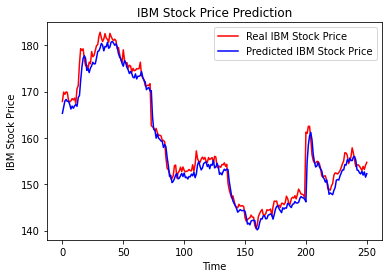

The root mean squared error is 2.0484657339528587.


In [ ]:
y_pred = Model3.predict(X_test)
y_pred = sc.inverse_transform(y_pred)
plt.plot(test, color='red',label='Real IBM Stock Price')
plt.plot(y_pred, color='blue',label='Predicted IBM Stock Price')
plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price')
plt.legend()
plt.show()
rmse = math.sqrt(mean_squared_error(test, y_pred))
print("The root mean squared error is {}.".format(rmse))

it's no longer improving so we'll stop the experimenting here

#weight initializers
now using the model we'll doing further experimentaion with weight initializers
zeros, ones, random normal, he normal, glorot normal

In [ ]:
def train_in_H1(ini):
    
   model = Sequential([
        Dense(units=64, input_shape=(60,),activation='relu',kernel_initializer=ini),
        Dense(units=8,activation='relu',kernel_initializer=ini),
        Dense(units=1,activation='linear',kernel_initializer=ini)
    ])

   model.compile(optimizer='adam',
                loss='mean_squared_error')
    
   return model 

In [ ]:
model_1 = train_in_H1('zeros')
model_1.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_89 (Dense)            (None, 64)                3904      
                                                                 
 dense_90 (Dense)            (None, 8)                 520       
                                                                 
 dense_91 (Dense)            (None, 1)                 9         
                                                                 
Total params: 4,433
Trainable params: 4,433
Non-trainable params: 0
_________________________________________________________________


In [ ]:
es = EarlyStopping(monitor='loss', verbose=1, patience=25)

model_1.fit(x_train, y_train, epochs=1000,verbose=0, callbacks=[es])

Epoch 44: early stopping


8/8 [==============================] - 0s 2ms/step


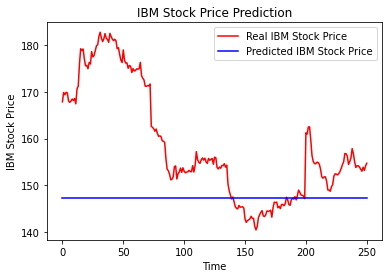

The root mean squared error is 16.57223159306657.


In [ ]:
y_pred = model_1.predict(X_test)
y_pred = sc.inverse_transform(y_pred)
plt.plot(test, color='red',label='Real IBM Stock Price')
plt.plot(y_pred, color='blue',label='Predicted IBM Stock Price')
plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price')
plt.legend()
plt.show()
rmse = math.sqrt(mean_squared_error(test, y_pred))
print("The root mean squared error is {}.".format(rmse))

No change

In [ ]:
model_2 = train_in_H1('ones')
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                3904      
                                                                 
 dense_1 (Dense)             (None, 8)                 520       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 4,433
Trainable params: 4,433
Non-trainable params: 0
_________________________________________________________________


In [ ]:
es = EarlyStopping(monitor='loss', verbose=1, patience=25)

model_2.fit(x_train, y_train, epochs=1000,verbose=0, callbacks=[es])

Epoch 391: early stopping


8/8 [==============================] - 0s 2ms/step


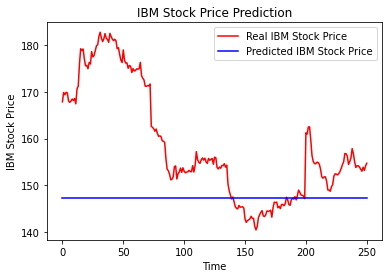

The root mean squared error is 16.54458207372766.


In [ ]:
y_pred = model_2.predict(X_test)
y_pred = sc.inverse_transform(y_pred)
plt.plot(test, color='red',label='Real IBM Stock Price')
plt.plot(y_pred, color='blue',label='Predicted IBM Stock Price')
plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price')
plt.legend()
plt.show()
rmse = math.sqrt(mean_squared_error(test, y_pred))
print("The root mean squared error is {}.".format(rmse))

In [ ]:
model_3 = train_in_H1('RandomNormal')
model_3.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_95 (Dense)            (None, 64)                3904      
                                                                 
 dense_96 (Dense)            (None, 8)                 520       
                                                                 
 dense_97 (Dense)            (None, 1)                 9         
                                                                 
Total params: 4,433
Trainable params: 4,433
Non-trainable params: 0
_________________________________________________________________


In [ ]:
es = EarlyStopping(monitor='loss', verbose=1, patience=25)

model_3.fit(x_train, y_train, epochs=1000,verbose=0, callbacks=[es])

Epoch 182: early stopping


8/8 [==============================] - 0s 2ms/step


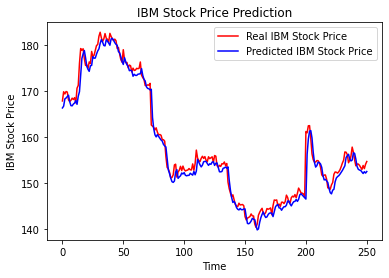

The root mean squared error is 1.8572709955554398.


In [ ]:
y_pred = model_3.predict(X_test)
y_pred = sc.inverse_transform(y_pred)
plt.plot(test, color='red',label='Real IBM Stock Price')
plt.plot(y_pred, color='blue',label='Predicted IBM Stock Price')
plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price')
plt.legend()
plt.show()
rmse = math.sqrt(mean_squared_error(test, y_pred))
print("The root mean squared error is {}.".format(rmse))

did better than one but not better than the default (glorot_uniform)

In [ ]:
model_4 = train_in_H1('he_normal')
model_4.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 64)                3904      
                                                                 
 dense_17 (Dense)            (None, 8)                 520       
                                                                 
 dense_18 (Dense)            (None, 1)                 9         
                                                                 
Total params: 4,433
Trainable params: 4,433
Non-trainable params: 0
_________________________________________________________________


In [ ]:
es = EarlyStopping(monitor='loss', verbose=1, patience=25)

model_4.fit(x_train, y_train, epochs=1000,verbose=0, callbacks=[es])

Epoch 177: early stopping


8/8 [==============================] - 0s 2ms/step


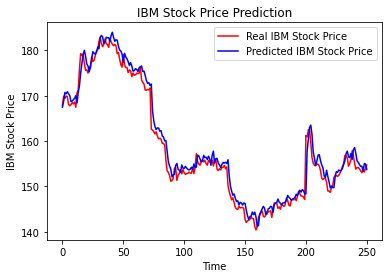

The root mean squared error is 2.034002462016471.


In [ ]:
y_pred = model_4.predict(X_test)
y_pred = sc.inverse_transform(y_pred)
plt.plot(test, color='red',label='Real IBM Stock Price')
plt.plot(y_pred, color='blue',label='Predicted IBM Stock Price')
plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price')
plt.legend()
plt.show()
rmse = math.sqrt(mean_squared_error(test, y_pred))
print("The root mean squared error is {}.".format(rmse))

In [ ]:
model_5 = train_in_H1('glorot_normal')
model_5.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_101 (Dense)           (None, 64)                3904      
                                                                 
 dense_102 (Dense)           (None, 8)                 520       
                                                                 
 dense_103 (Dense)           (None, 1)                 9         
                                                                 
Total params: 4,433
Trainable params: 4,433
Non-trainable params: 0
_________________________________________________________________


In [ ]:
es = EarlyStopping(monitor='loss', verbose=1, patience=25)

model_5.fit(x_train, y_train, epochs=1000,verbose=0, callbacks=[es])

Epoch 107: early stopping


8/8 [==============================] - 0s 2ms/step


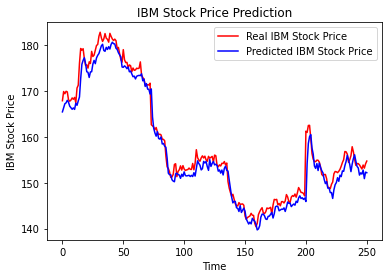

The root mean squared error is 2.226744280319312.


In [ ]:
y_pred = model_5.predict(X_test)
y_pred = sc.inverse_transform(y_pred)
plt.plot(test, color='red',label='Real IBM Stock Price')
plt.plot(y_pred, color='blue',label='Predicted IBM Stock Price')
plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price')
plt.legend()
plt.show()
rmse = math.sqrt(mean_squared_error(test, y_pred))
print("The root mean squared error is {}.".format(rmse))

None of them beat the default model

#final Stage
here we will try different patience
we will start with 50 and keep adding 50 then 100 to then 200

In [ ]:
modelFinal = Sequential([
        Dense(units=64, input_shape=(60,),activation='relu'),
        Dense(units=8,activation='relu'),
        Dense(units=1,activation='linear')
    ])

modelFinal.compile(optimizer='adam',
            loss='mean_squared_error')

In [ ]:
es = EarlyStopping(monitor='loss', verbose=1, patience=50)

modelFinal.fit(x_train, y_train, epochs=1000,verbose=0, callbacks=[es])

Epoch 324: early stopping


8/8 [==============================] - 0s 2ms/step


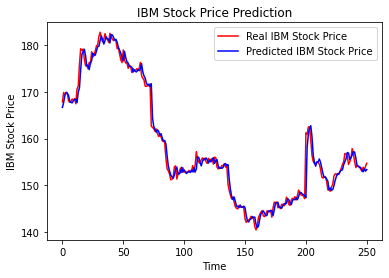

The root mean squared error is 1.6040706662976383.


In [ ]:
y_pred = modelFinal.predict(X_test)
y_pred = sc.inverse_transform(y_pred)
plt.plot(test, color='red',label='Real IBM Stock Price')
plt.plot(y_pred, color='blue',label='Predicted IBM Stock Price')
plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price')
plt.legend()
plt.show()
rmse = math.sqrt(mean_squared_error(test, y_pred))
print("The root mean squared error is {}.".format(rmse))

In [ ]:
modelFinal2 = Sequential([
        Dense(units=64, input_shape=(60,),activation='relu'),
        Dense(units=8,activation='relu'),
        Dense(units=1,activation='linear')
    ])

modelFinal2.compile(optimizer='adam',
            loss='mean_squared_error')

In [ ]:
es = EarlyStopping(monitor='loss', verbose=1, patience=100)

modelFinal2.fit(x_train, y_train, epochs=1000,verbose=0, callbacks=[es])

Epoch 373: early stopping


8/8 [==============================] - 0s 2ms/step


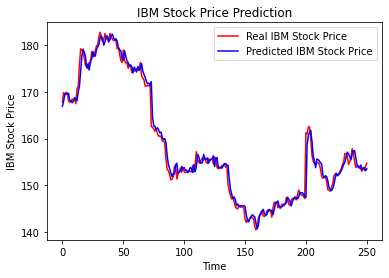

The root mean squared error is 1.6294780914607971.


In [ ]:
y_pred = modelFinal2.predict(X_test)
y_pred = sc.inverse_transform(y_pred)
plt.plot(test, color='red',label='Real IBM Stock Price')
plt.plot(y_pred, color='blue',label='Predicted IBM Stock Price')
plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price')
plt.legend()
plt.show()
rmse = math.sqrt(mean_squared_error(test, y_pred))
print("The root mean squared error is {}.".format(rmse))

In [ ]:
modelFinal3 = Sequential([
        Dense(units=64, input_shape=(60,),activation='relu'),
        Dense(units=8,activation='relu'),
        Dense(units=1,activation='linear')
    ])

modelFinal3.compile(optimizer='adam',
            loss='mean_squared_error')

In [ ]:
es = EarlyStopping(monitor='loss', verbose=1, patience=200)

modelFinal3.fit(x_train, y_train, epochs=1000,verbose=0, callbacks=[es])

8/8 [==============================] - 0s 2ms/step


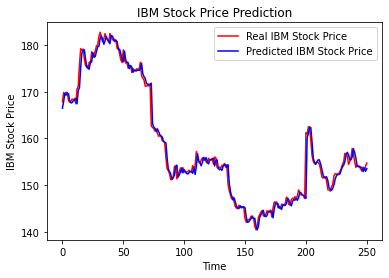

The root mean squared error is 1.5711506059423939.


In [ ]:
y_pred = modelFinal3.predict(X_test)
y_pred = sc.inverse_transform(y_pred)
plt.plot(test, color='red',label='Real IBM Stock Price')
plt.plot(y_pred, color='blue',label='Predicted IBM Stock Price')
plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price')
plt.legend()
plt.show()
rmse = math.sqrt(mean_squared_error(test, y_pred))
print("The root mean squared error is {}.".format(rmse))

In [ ]:
modelFinal4 = Sequential([
        Dense(units=64, input_shape=(60,),activation='relu'),
        Dense(units=8,activation='relu'),
        Dense(units=1,activation='linear')
    ])

modelFinal4.compile(optimizer='adam',
            loss='mean_squared_error')

In [ ]:
es = EarlyStopping(monitor='loss', verbose=1, patience=200)

modelFinal4.fit(x_train, y_train, epochs=5000,verbose=0, callbacks=[es])

Epoch 1675: early stopping


In [ ]:
y_pred = modelFinal4.predict(X_test)
y_pred = sc.inverse_transform(y_pred)
rmse = math.sqrt(mean_squared_error(test, y_pred))
print("The root mean squared error is {}.".format(rmse))

8/8 [==============================] - 0s 5ms/step
The root mean squared error is 1.696930472455559.


#load
saving the model with the code:

In [ ]:
# serialize model to JSON
model_json = modelFinal3.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
modelFinal3.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
from tensorflow.keras.models import Sequential, model_from_json

Load the model

In [ ]:
# load json and create model
json_file = open('modelFinal.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("modelFinal.h5")
print("Loaded model from disk")

Loaded model from disk


How the model looks like

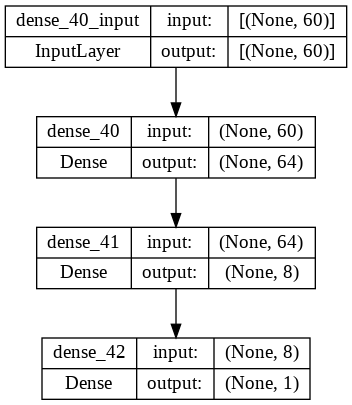

In [ ]:
tf.keras.utils.plot_model(loaded_model, show_shapes= True)

#final testing
so here we'll use the model we approved to try to predict 2018 IBM stocks

In [ ]:
import yfinance as yf

In [ ]:
data2 = yf.download('IBM', start='2018-01-01', end='2019-01-01')
print(data2.shape)
data2

[*********************100%***********************]  1 of 1 completed
(251, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,147.705551,148.001907,146.787766,147.466537,116.036690,4395815
2018-01-03,150.420654,152.782028,149.455063,151.520081,119.226318,9875914
2018-01-04,152.629059,155.181641,152.361374,154.588913,121.641090,7903785
2018-01-05,155.296371,155.736145,154.015289,155.344162,122.235382,5434807
2018-01-08,155.506699,156.701721,154.588913,156.281067,122.972618,5478425
...,...,...,...,...,...,...
2018-12-24,105.066925,106.118546,102.772469,102.839386,84.581276,3997184
2018-12-26,103.250481,106.491394,101.281075,106.491394,87.584900,6951507
2018-12-27,105.152962,108.776291,104.655830,108.776291,89.464134,6323698


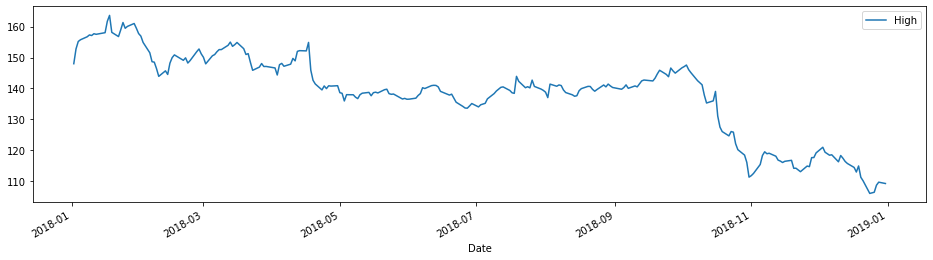

In [ ]:
data2["High"].plot(figsize=(16,4),legend=True)

In [ ]:
test2 = data2.iloc[:,1:2].values

In [ ]:
data_total2 = pd.concat((data["High"][:'2017'],data2["High"]),axis=0)
inputs = data_total2[len(data_total2)-len(test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [ ]:
len(test2)+60

311

In [ ]:
X_test2 = []
for i in range(60,311):
    X_test2.append(inputs[i-60:i,0])
X_test2 = np.array(X_test2)
X_test2 = np.reshape(X_test2, (X_test2.shape[0],X_test2.shape[1],1))

8/8 [==============================] - 0s 3ms/step


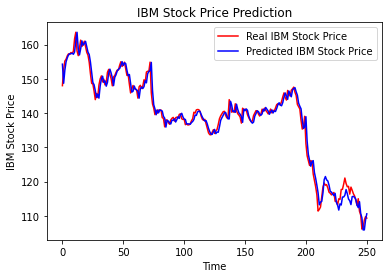

The root mean squared error is 1.9641664045004243.


In [ ]:
y_pred = loaded_model.predict(X_test2)
y_pred = sc.inverse_transform(y_pred)
plt.plot(test2, color='red',label='Real IBM Stock Price')
plt.plot(y_pred, color='blue',label='Predicted IBM Stock Price')
plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price')
plt.legend()  
plt.show()
rmse = math.sqrt(mean_squared_error(test2, y_pred))
print("The root mean squared error is {}.".format(rmse))

#Trying The LSTM layers
User SIDDHARTH YADAV used LSTM layers so here we will try his neural network with early stopping.
https://www.kaggle.com/code/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru/notebook

In [ ]:
from keras.layers import LSTM, Dropout

In [ ]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

es = EarlyStopping(monitor='loss', verbose=1, patience=25)

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(x_train,y_train,epochs=1000,batch_size=32, callbacks=[es])

Epoch 1/1000
85/85 [==============================] - 23s 125ms/step - loss: 0.0209
Epoch 2/1000
85/85 [==============================] - 10s 122ms/step - loss: 0.0106
Epoch 3/1000
85/85 [==============================] - 10s 122ms/step - loss: 0.0088
Epoch 4/1000
85/85 [==============================] - 10s 122ms/step - loss: 0.0072
Epoch 5/1000
85/85 [==============================] - 10s 122ms/step - loss: 0.0064
Epoch 6/1000
85/85 [==============================] - 10s 122ms/step - loss: 0.0054
Epoch 7/1000
85/85 [==============================] - 12s 142ms/step - loss: 0.0048
Epoch 8/1000
85/85 [==============================] - 10s 123ms/step - loss: 0.0045
Epoch 9/1000
85/85 [==============================] - 11s 128ms/step - loss: 0.0043
Epoch 10/1000
85/85 [==============================] - 10s 122ms/step - loss: 0.0042
Epoch 11/1000
85/85 [==============================] - 10s 122ms/step - loss: 0.0038
Epoch 12/1000
85/85 [==============================] - 10s 122ms/step - lo

8/8 [==============================] - 0s 57ms/step


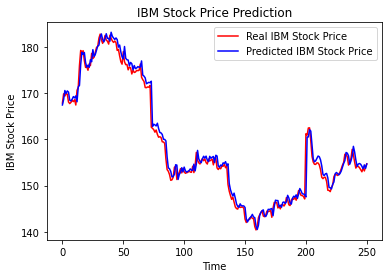

The root mean squared error is 1.663606802461618.


In [ ]:
y_pred = regressor.predict(X_test)
y_pred = sc.inverse_transform(y_pred)
plt.plot(test, color='red',label='Real IBM Stock Price')
plt.plot(y_pred, color='blue',label='Predicted IBM Stock Price')
plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price')
plt.legend()  
plt.show()
rmse = math.sqrt(mean_squared_error(test, y_pred))
print("The root mean squared error is {}.".format(rmse))